# Introduction

Author: Harneet Rishi

Purpose: Generate figures and analysis for Section 2 (essential gene enrichment, controls, assessment of biases for CRISPRi library)

# Imports

## Modules/packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.stats.multitest as smm
from scipy.special import comb
from scipy.stats import hypergeom
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

## Functions

### Effect size calculations

In [2]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [3]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

## Data

### sgRNA annotations

In [4]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head(10)

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0
cgtactgctcgggcccgaaa,cgtactgctcgggcccgaaa,2751592,+,Promoter,,NaN,NaN,0
ggaaaagttttgcgctatgt,ggaaaagttttgcgctatgt,2554,+,Promoter,,NaN,NaN,0
tagtccttccccttacggga,tagtccttccccttacggga,137014,-,Promoter,,NaN,NaN,0
tggttttatatacagtaaag,tggttttatatacagtaaag,2749746,-,Promoter,,NaN,NaN,0


In [5]:
# Essential genes based on PEC database
list_genes_ess = list(set(df_sgRNA_info_update_3[df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)'] == 1]['gene_name_F2'].values))

In [6]:
# Conditionally Essential Genes in M9 (1% glycerol), aerobic, T=37C (Joyce et al J.Bac 2006)
M9_ess = 'argA , argE , argH , aroA , aroB , aroC , aroE , atpA , atpB , atpC , atpF , atpG , atpH , carA , carB , cra , crr , cysA , cysB , cysC , cysD , cysE , cysH , cysI , cysJ , cysK , cysN , cysP , cysQ , cysU , fes , folB , glnA , glpD , glpK , gltA , glyA , guaA , guaB , hisA , hisB , hisC , hisD , hisF , hisG , hisH , hisI , icd , ilvA , ilvB , ilvC , ilvD , iscS , leuA , leuB , leuC , leuD , leuL , lysA , metA , metB , metC , metF , metL , metR , nadA , nadB , nadC , pabA , pabB , panB , panC , panD , panZ , pdxA , pdxB , pdxH , pdxJ , pheA , ppc , proA , proB , proC , ptsI , purA , purC , purD , purE , purF , purH , purK , purL , purM , pyrB , pyrC , pyrD , pyrE , pyrF , serA , serB , serC , thrA , thrB , thrC , thyA , trpA , trpB , trpC , trpD , trpE , tyrA , ubiG , ubiH'.split(',')
M9_ess = [g.replace(' ', '') for g in M9_ess]

### p-values

In [7]:
df_topd24t0_LB = pd.read_csv('SourceData/edgeR_3-topd24t0_LB_ae.csv')
df_topd24t0_LB.set_index(keys = 'seq', inplace = True, drop = False)
df_topd24t0_LB.head()

,seq,gene_name,spacer_id,logFC,logCPM,PValue,FDR
seq,,,,,,,
caatacgttgtgctagttcc,caatacgttgtgctagttcc,prs,caatacgttgtgctagttcc_prs,-11.605178,5.513031,3.057221e-96,3.132417e-94
cgcgatccaccagtaagaac,cgcgatccaccagtaagaac,fabZ,cgcgatccaccagtaagaac_fabZ,-11.402736,5.307910,3.035710e-179,1.192311e-176
agtcacctgctgccccacgt,agtcacctgctgccccacgt,aspS,agtcacctgctgccccacgt_aspS,-11.212790,5.106886,8.700724e-56,3.797014e-54
aaaagtcgagaaacgcctga,aaaagtcgagaaacgcctga,alaS,aaaagtcgagaaacgcctga_alaS,-11.164131,5.057755,1.252057e-52,5.031408e-51
accaaaaatggaaagcgttc,accaaaaatggaaagcgttc,thyA,accaaaaatggaaagcgttc_thyA,-11.140033,5.039507,2.698944e-43,8.578378e-42


### Fitness values

In [8]:
# Figure 2A
df_LRs_GEq_2e6 = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6.csv')
df_LRs_GEq_2e6_nmed = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6_nmed.csv')
df_LRs_GEq_2e6_nmed.set_index(keys = 'seq', inplace = True, drop = False)

cols_LB = [u'd24_tR2_LR_nmed', u'd24_tR3_LR_nmed', u'ET165_LB_ae_d24_B5T2_LR_nmed', u'ET165_LB_ae_d24_B6T2_LR_nmed',
           u'ET165_R1_1.25mL_d24_LR_nmed', u'ET165_R2_1.25mL_d24_LR_nmed', u'ET165_R3.1_1mL_d24_LR_nmed',
           u'ET165_R3.2_1mL_d24_LR_nmed', u'ET165_R4_2mL_d24_LR_nmed']
cols_M9Ca = [ u'M9_B2T1_d24_Ca_LR_nmed', u'M9_B2T2_d24_Ca_LR_nmed', u'M9_B2T3_d24_Ca_LR_nmed']
cols_M9 = [u'M9_B2T1_d24_LR_nmed', u'M9_B2T2_d24_LR_nmed', u'M9_B2T3_d24_LR_nmed']

df_LRs_GEq_2e6_nmed['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_LB].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9Ca_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9Ca].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9].mean(axis = 1)

cols_to_transfer = [u'strand', u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
for col in cols_to_transfer:
    df_LRs_GEq_2e6_nmed[col] = df_sgRNA_info_update_3[col]
    
sel_cols = ['seq','LB_ae_avgLR_nmed', 'M9Ca_ae_avgLR_nmed', 'M9_ae_avgLR_nmed',
            u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly',
            u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed[sel_cols]

df_LRs_GEq_2e6_nmed_selcols['LB_logFC'] = df_topd24t0_LB['logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_FDR'] = df_topd24t0_LB['FDR']

In [9]:
df_LRs_GEq_2e6_nmed_selcols.head()

,seq,LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown),LB_logFC,LB_FDR
seq,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,0.189134,-0.027225,-5.074150,88.0,32.0,All_Genes,thr operon leader peptide,thrL,b0001,2,-0.076977,0.825065
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,0.462671,0.044080,0.368444,83.0,44.0,All_Genes,conserved protein,ybiI,b0803,2,0.326304,0.180549
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,0.102828,0.509944,0.971665,61.0,21.0,All_Genes,predicted protein,ybiU,b0821,2,-0.118003,0.827344
tcttgactggctaatgcacg,tcttgactggctaatgcacg,0.245104,0.053096,0.414547,92.0,36.0,All_Genes,poly-&beta;-16-N-acetyl-D-glucosamine N-deacet...,pgaB,b1023,2,0.168139,0.617684
ccgaactccctgattccttt,ccgaactccctgattccttt,-0.135161,-1.398016,-0.414700,55.0,26.0,All_Genes,conserved protein,yqiC,b3042,2,-0.029368,0.981703


In [10]:
# Figure 2B
df_allLRS = pd.read_csv('SourceData/APAHR014_3-df_allLRS.csv')
df_allLRS.set_index(keys = 'seq', inplace = True, drop = False)
df_allLRS.head()

,seq,ET165_LB_ae_t0_B5,ET165_LB_ae_d24_B5T1_LR,ET165_LB_ae_d24_B5T2_LR,ET165_LB_ae_drift_B1d24_LR,ET165_LB_ae_drift_B1sat_LR,ET165_LB_ae_leak_B1d24_LR,ET165_LB_ae_leak_B1sat_LR,ET165_LB_ae_sat_B5T1_LR,ET165_LB_ae_sat_B5T2_LR,ET165_LB_ae_d24_B5T1_LR_nmed,ET165_LB_ae_d24_B5T2_LR_nmed,ET165_LB_ae_drift_B1d24_LR_nmed,ET165_LB_ae_drift_B1sat_LR_nmed,ET165_LB_ae_leak_B1d24_LR_nmed,ET165_LB_ae_leak_B1sat_LR_nmed,ET165_LB_ae_sat_B5T1_LR_nmed,ET165_LB_ae_sat_B5T2_LR_nmed,ET165_LB_ae_t0_B6,ET165_LB_ae_d24_B6T1_LR,ET165_LB_ae_d24_B6T2_LR,ET165_LB_ae_drift_B2d24_LR,ET165_LB_ae_drift_B2sat_LR,ET165_LB_ae_leak_B2d24_LR,ET165_LB_ae_leak_B2sat_LR,ET165_LB_ae_sat_B6T1_LR,ET165_LB_ae_sat_B6T2_LR,ET165_LB_ae_d24_B6T1_LR_nmed,ET165_LB_ae_d24_B6T2_LR_nmed,ET165_LB_ae_drift_B2d24_LR_nmed,ET165_LB_ae_drift_B2sat_LR_nmed,ET165_LB_ae_leak_B2d24_LR_nmed,ET165_LB_ae_leak_B2sat_LR_nmed,ET165_LB_ae_sat_B6T1_LR_nmed,ET165_LB_ae_sat_B6T2_LR_nmed,ET165_LB_ae_t0_B7,ET165_LB_ae_d24_B7T1_LR,ET165_LB_ae_d24_B7T2_LR,ET165_LB_ae_sat_B7T1_LR,ET165_LB_ae_sat_B7T2_LR,ET165_LB_ae_d24_B7T1_LR_nmed,ET165_LB_ae_d24_B7T2_LR_nmed,ET165_LB_ae_sat_B7T1_LR_nmed,ET165_LB_ae_sat_B7T2_LR_nmed,ET165_LB_ae_t0_B8,ET165_LB_ae_d24_B8T1_LR,ET165_LB_ae_d24_B8T2_LR,ET165_LB_ae_sat_B8T1_LR,ET165_LB_ae_sat_B8T2_LR,ET165_LB_ae_d24_B8T1_LR_nmed,ET165_LB_ae_d24_B8T2_LR_nmed,ET165_LB_ae_sat_B8T1_LR_nmed,ET165_LB_ae_sat_B8T2_LR_nmed,seq.1,pos,strand,category,gene_name
seq,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,40.0,-0.275575,0.198741,0.186769,-0.102738,0.115685,-0.043054,0.201415,-0.187627,-0.490780,-0.005178,0.201415,-0.066321,0.101880,-0.033139,0.182800,-0.211214,37.0,0.085496,0.349859,0.064955,0.314315,0.018859,0.144390,-0.071339,0.417408,-0.110424,0.171714,0.095329,0.293966,0.058605,0.137726,-0.040571,0.458050,63.0,0.386786,-0.088872,-0.043069,0.096862,0.149747,-0.308838,-0.050626,0.055282,50.0,0.298428,0.134930,-0.032180,0.197665,0.134930,-0.043069,-0.029638,0.171670,ggtggtgctaatgcgtttca,191,-,All_Genes,thrL
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,37.0,0.298718,0.433897,-0.401044,-0.165295,0.116376,-0.049197,-0.184918,0.159037,0.083512,0.229978,-0.386397,-0.128877,0.102570,-0.039281,-0.203533,0.135450,46.0,0.259962,0.017435,-0.149447,-0.117877,-0.457015,-0.461832,-0.378000,-0.162271,0.064041,-0.160711,-0.119074,-0.138226,-0.417269,-0.468495,-0.347233,-0.121629,42.0,1.168326,0.659950,0.553034,1.092061,0.931287,0.439984,0.545477,1.050481,57.0,0.236255,0.338416,0.015463,-0.184927,0.072756,0.160418,0.018005,-0.210922,cggaatttcaccccgagcgc,837587,+,All_Genes,ybiI
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,15.0,0.482515,1.063695,0.444785,0.424739,0.392317,0.548268,0.532495,0.822002,0.267309,0.859776,0.459432,0.461156,0.378512,0.558183,0.513879,0.798415,19.0,0.981122,0.931413,0.095924,0.655352,0.469660,0.240314,0.600904,0.485427,0.785202,0.753267,0.126298,0.635003,0.509406,0.233651,0.631671,0.526069,25.0,0.291487,1.343954,0.343954,0.589067,0.054448,1.123989,0.336397,0.547488,30.0,0.635567,0.318822,-0.059379,0.268196,0.472068,0.140824,-0.056836,0.242201,atcggcaggcaatgtgtcgc,858246,+,All_Genes,ybiU
tcttgactggctaatgcacg,tcttgactggctaatgcacg,35.0,0.553598,0.261921,-0.008933,-0.379058,0.249873,0.168705,-0.304855,-0.088537,0.338393,0.058002,0.005714,-0.342641,0.236067,0.178620,-0.323470,-0.112123,26.0,0.800929,0.666576,0.557995,0.160992,0.270372,0.300395,0.374396,0.724893,0.605008,0.488431,0.588369,0.140643,0.310119,0.293731,0.405163,0.765535,42.0,0.876864,0.285554,0.312026,-0.182562,0.639824,0.065588,0.304469,-0.224141,33.0,1.225783,0.281771,0.243454,0.437492,1.062284,0.103773,0.245996,0.411497,tcttgactggctaatgcacg,1089003,+,All_Genes,pgaB
ccgaactccctgattccttt,ccgaactccctgattccttt,28.0,-0.719420,-0.289814,-0.133088,-0.224655,0.062715,-0.065525,-0.379934,-0.379934,-0.934626,-0.493732,-0.118441,-0.188238,0.048910,-0.055609,-0.398549,-0.403521,34.0,-0.680382,-0.679250,-1.052467,-0.213404,-0.275634,-0.321928,-0.549339,0.263034,-0.876302,-0.8573

In [11]:
# df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['category'] == 'All_Genes'].to_csv('df_LRs_GEq_2e6_nmed_selcols_All_Genes.csv')

# Figures

In [12]:
df_LRs_GEq_2e6_nmed_selcols.describe()

,LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,Class(1:essential 2:noessential 3:unknown),LB_logFC,LB_FDR
count,32992.000000,32992.000000,32992.000000,32992.000000,32992.000000,32992.000000,32992.000000,32992.000000
mean,-0.504811,-0.528898,-0.573683,86.182408,35.619271,1.032462,-0.577174,0.523858
std,1.568991,1.612408,1.757621,89.412446,37.083421,0.991037,1.842266,0.360043
min,-9.111689,-8.149879,-8.046564,0.000000,0.000000,0.000000,-11.605178,0.000000
25%,-0.385453,-0.682830,-1.039672,24.000000,10.000000,0.000000,-0.297339,0.153608
50%,0.019752,0.005111,0.021705,55.000000,23.000000,1.000000,0.008950,0.581529
75%,0.231503,0.386213,0.550854,118.000000,49.000000,2.000000,0.181346,0.862743
max,2.025634,3.201349,3.629338,880.000000,360.000000,3.000000,3.485330,1.000000


## Figure 2a

### Visualize

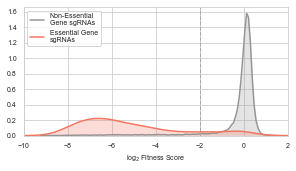

In [13]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

df_Ess_t0 = df_LRs_GEq_2e6_nmed_selcols[(df_LRs_GEq_2e6_nmed_selcols['Class(1:essential 2:noessential 3:unknown)'] == 1) &
                                       (df_LRs_GEq_2e6_nmed_selcols['ET165_LB_ae_t0'] >= 10)]
df_Ess_t0 = df_Ess_t0[df_Ess_t0['gene_name_F2'] != 'b2651'] #b2651 was found to be phantom gene
df_NonEss_t0 = df_LRs_GEq_2e6_nmed_selcols[(df_LRs_GEq_2e6_nmed_selcols['Class(1:essential 2:noessential 3:unknown)'] == 2) &
                                       (df_LRs_GEq_2e6_nmed_selcols['ET165_LB_ae_t0'] >= 10)]


sns.kdeplot(df_NonEss_t0['LB_ae_avgLR_nmed'], shade = True, color = sns.color_palette('Greys',3)[1], label = 'Non-Essential\nGene sgRNAs')
sns.kdeplot(df_Ess_t0['LB_ae_avgLR_nmed'], shade = True, color = '#F37560', label = 'Essential Gene\nsgRNAs')
plt.axvline(x=-2, ymin=0, ymax = 1, linewidth=1, color='darkgray', linestyle = '--')
plt.xlim([-10,2])
plt.legend(loc = 'upper left', fontsize = 7, frameon = True)
plt.xlabel(r'log$_2$ Fitness Score', fontsize = 7)
plt.tick_params(axis = 'both', which = 'major', labelsize = 7)

plt.savefig('Section 2/Fig_2_a_tht0=10_AltColor_AltDim.pdf', type = 'pdf')

### Stats

In [14]:
# Mann-whitney U-test
x = df_Ess_t0['LB_ae_avgLR_nmed'].values
y = df_NonEss_t0['LB_ae_avgLR_nmed'].values
statistics, pvalue = mannwhitneyu(x, y, alternative='two-sided')
statistics, pvalue

(885333.5, 0.0)

In [15]:
# Cohen's d effect size calculation
x = df_Ess_t0['LB_ae_avgLR_nmed'].values
y = df_NonEss_t0['LB_ae_avgLR_nmed'].values
mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)
cohens_d

3.7461477504293663

### Data Export

In [16]:
df_Fig2a = pd.concat([df_Ess_t0, df_NonEss_t0], axis=0)
df_Fig2a = df_Fig2a[['LB_ae_avgLR_nmed', 'ET165_LB_ae_t0', 'category', 'product_name', 'gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)', 'LB_FDR']].reset_index(drop=False)
df_Fig2a.to_excel('Section 2/Table_Fig-2a.xlsx')
df_Fig2a

,seq,LB_ae_avgLR_nmed,ET165_LB_ae_t0,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown),LB_FDR
0,acccaatctctgtctttgac,-4.190483,34.0,All_Genes,fused tRNA nucleotidyltransferase / 2'3'-cycli...,cca,b3056,1,2.543817e-37
1,cccgcgtcgagcatctcctg,1.045230,20.0,All_Genes,fused tRNA nucleotidyltransferase / 2'3'-cycli...,cca,b3056,1,2.794976e-01
2,gaaaatcgcggcctacctgc,0.139603,21.0,All_Genes,fused tRNA nucleotidyltransferase / 2'3'-cycli...,cca,b3056,1,9.201032e-01
3,caaaacgcgccccctcgacg,-0.767361,197.0,All_Genes,dihydroneopterin aldolase,folB,b3058,1,4.992655e-04
4,catcacttttcgccgcttta,-0.379029,149.0,All_Genes,dihydroneopterin aldolase,folB,b3058,1,1.559398e-01
...,...,...,...,...,...,...,...,...,...
16957,aaacgccagtaagcggttcg,-0.255295,237.0,All_Genes,heavy metal divalent cation transporter ZupT,zupT,b3040,2,5.558797e-01
16958,ggcattgctttccagaatat,-1.792866,200.0,All_Genes,ThrA,thrA,b0002,2,2.005618e-12
16959,gtataaatgatgttcttgac,-0.676886,28.0,All_Genes,poly-&beta;-16-N-acetyl-D-glucosamine N-deacet...,pgaB,b1023,2,3.631901e-01
16960,gcgatttgctcaattttttt,0.285491,47.0,All_Genes,conserved protein,yqiC,b3042,2,9.004604e-01


## Depletion calculations

In [17]:
df_Ess_t0_gpby = df_Ess_t0.groupby('gene_name_F2').median()
df_Ess_t0_gpby['gene_name_F2'] = df_Ess_t0_gpby.index
df_Ess_t0_gpby

,LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,Class(1:essential 2:noessential 3:unknown),LB_logFC,LB_FDR,gene_name_F2
gene_name_F2,,,,,,,,,
accA,-6.603346,-4.493641,-4.264347,107.5,32.0,1,-8.099881,3.900711e-38,accA
accB,-7.705001,-5.701436,-5.541315,221.5,60.0,1,-7.761764,6.588703e-56,accB
accC,-6.174842,-4.184924,-4.093976,101.5,34.5,1,-6.729985,1.966324e-45,accC
accD,-7.174079,-5.842338,-5.682217,145.5,49.5,1,-8.775565,2.692907e-77,accD
acpP,-6.813555,-4.224139,-3.978533,205.5,92.5,1,-6.611606,1.142766e-39,acpP
...,...,...,...,...,...,...,...,...,...
yihA,-4.923629,-4.563640,-3.987067,92.0,30.5,1,-4.851465,8.319701e-64,yihA
yqgD,-0.013873,-1.333442,-3.120342,50.5,24.0,1,-0.042969,6.336372e-01,yqgD
yqgF,-1.498705,-1.550496,-0.503702,73.5,33.5,1,-1.539881,4.626926e-01,yqgF


In [18]:
# Fraction of PEC essential genes in library with composite fitness score <= -2
len(df_Ess_t0_gpby[df_Ess_t0_gpby['LB_ae_avgLR_nmed'] <= -2]), len(df_Ess_t0_gpby), (len(df_Ess_t0_gpby[df_Ess_t0_gpby['LB_ae_avgLR_nmed'] <= -2])/len(df_Ess_t0_gpby))


(274, 303, 0.9042904290429042)

In [19]:
df_Ess_t0_gpby_withsgRNAscores = df_Ess_t0_gpby.copy()
list_colnames = [('LB_ae_avgLR_nmed', 'LB_avgLR_nmed scores'),
                 ('ET165_LB_ae_t0', 'LB t0 counts'),
                 ('M9_t0_BR2_glu+gly', 'M9 t0 counts'),
                 ('LB_logFC', 'LB_logFC scores'),
                 ('LB_FDR', 'LB_FDR values')]
for (colname, newcol) in list_colnames:
    df_Ess_t0_gpby_withsgRNAscores[newcol] = df_Ess_t0_gpby_withsgRNAscores['gene_name_F2'].apply(lambda gene:
        df_LRs_GEq_2e6_nmed_selcols[(df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene) & 
                                    (df_LRs_GEq_2e6_nmed_selcols['ET165_LB_ae_t0'] >= 10)][colname].values)
df_Ess_t0_gpby_withsgRNAscores

,LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,Class(1:essential 2:noessential 3:unknown),LB_logFC,LB_FDR,gene_name_F2,LB_avgLR_nmed scores,LB t0 counts,M9 t0 counts,LB_logFC scores,LB_FDR values
gene_name_F2,,,,,,,,,,,,,,
accA,-6.603346,-4.493641,-4.264347,107.5,32.0,1,-8.099881,3.900711e-38,accA,"[-8.131141487080235, -7.22962070455461, -4.621...","[203.0, 155.0, 16.0, 60.0]","[83.0, 46.0, 7.0, 18.0]","[-10.846692765673199, -8.410557515231579, -7.5...","[4.2846781213663886e-135, 1.4190500049261196e-..."
accB,-7.705001,-5.701436,-5.541315,221.5,60.0,1,-7.761764,6.588703e-56,accB,"[-8.072075870592947, -7.582708894028946, -7.82...","[221.0, 300.0, 222.0, 202.0]","[56.0, 88.0, 64.0, 45.0]","[-10.620852880296098, -6.06539610744022, -8.87...","[2.769593654353739e-75, 1.63734011790939e-08, ..."
accC,-6.174842,-4.184924,-4.093976,101.5,34.5,1,-6.729985,1.966324e-45,accC,"[-4.696086099887562, -7.061449471397087, -5.82...","[95.0, 180.0, 43.0, 108.0]","[26.0, 71.0, 20.0, 43.0]","[-4.73518398577949, -6.87175366121634, -7.6494...","[9.9205293537454e-30, 1.0321046817328299e-54, ..."
accD,-7.174079,-5.842338,-5.682217,145.5,49.5,1,-8.775565,2.692907e-77,accD,"[-7.111255728984228, -8.129104482634283, -7.23...","[107.0, 209.0, 184.0, 89.0]","[45.0, 54.0, 65.0, 35.0]","[-9.25764369948888, -10.9289314337992, -8.2934...","[3.908792112640809e-85, 8.299422260333058e-80,..."
acpP,-6.813555,-4.224139,-3.978533,205.5,92.5,1,-6.611606,1.142766e-39,acpP,"[-7.008273431069181, -2.2923202163059364, -6.6...","[144.0, 212.0, 199.0, 248.0]","[95.0, 92.0, 93.0, 87.0]","[-8.29223601349417, -2.4961016204376603, -4.93...","[1.0656482283702298e-48, 2.2855326780073198e-3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yihA,-4.923629,-4.563640,-3.987067,92.0,30.5,1,-4.851465,8.319701e-64,yihA,"[-5.14147982938626, -5.632034925488321, -2.193...","[74.0, 82.0, 102.0, 107.0]","[28.0, 23.0, 33.0, 40.0]","[-5.215138603449, -5.77393889127105, -1.975654...","[1.6614598245179499e-63, 2.4803301359487096e-6..."
yqgD,-0.013873,-1.333442,-3.120342,50.5,24.0,1,-0.042969,6.336372e-01,yqgD,"[0.24138270387704105, -0.09796512607396837, 0....","[104.0, 33.0, 34.0, 67.0]","[48.0, 18.0, 10.0, 30.0]","[0.215695729462676, -0.0946590009771417, 0.008...","[0.34142669686510696, 0.9258476485671179, 1.0,..."
yqgF,-1.498705,-1.550496,-0.503702,73.5,33.5,1,-1.539881,4.626926e-01,yqgF,"[0.030987053604998052, -3.028397002238674, -3....","[73.0, 171.0, 35.0, 74.0]","[35.0, 63.0, 13.0, 32.0]","[-0.0605802053764806, -3.0191812984463797, -4....","[0.9265262431335629, 1.3030566401955897e-53, 1..."


In [20]:
df_Ess_t0_gpby_withsgRNAscores[df_Ess_t0_gpby_withsgRNAscores['LB_ae_avgLR_nmed'] > -2].to_csv(
    'Section 2/df_Ess_t0_gpby median gene score > -2.csv')

In [21]:
df_Ess_t0_gpby_withsgRNAscores[df_Ess_t0_gpby_withsgRNAscores['LB_ae_avgLR_nmed'] > -1].to_csv('Section 2/df_Ess_t0_gpby median gene score > -1.csv')

## Figure 2b

### Process

In [22]:
cols_drift_leak = [col for col in df_allLRS if ((('drift' in col or 'leak' in col) and ('nmed' not in col)) and ('sat' not in col) )]
cols_drift_leak

['ET165_LB_ae_drift_B1d24_LR',
 'ET165_LB_ae_leak_B1d24_LR',
 'ET165_LB_ae_drift_B2d24_LR',
 'ET165_LB_ae_leak_B2d24_LR']

In [23]:
df_drift_leak = df_allLRS[cols_drift_leak]
for col in ['gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)']:
    df_drift_leak[col] = df_sgRNA_info_update_3[col]
df_drift_leak

,ET165_LB_ae_drift_B1d24_LR,ET165_LB_ae_leak_B1d24_LR,ET165_LB_ae_drift_B2d24_LR,ET165_LB_ae_leak_B2d24_LR,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,
ggtggtgctaatgcgtttca,0.186769,0.115685,0.064955,0.018859,thrL,b0001,2
cggaatttcaccccgagcgc,-0.401044,0.116376,-0.149447,-0.457015,ybiI,b0803,2
atcggcaggcaatgtgtcgc,0.444785,0.392317,0.095924,0.469660,ybiU,b0821,2
tcttgactggctaatgcacg,-0.008933,0.249873,0.557995,0.270372,pgaB,b1023,2
ccgaactccctgattccttt,-0.133088,0.062715,-1.052467,-0.275634,yqiC,b3042,2
...,...,...,...,...,...,...,...
tgagttgatttaccgccggt,-0.288569,0.264129,0.450033,0.041223,sroG,NaN,3
gagttgatttaccgccggtg,-1.076266,0.020826,0.466318,0.321268,sroG,NaN,3
cgccccgccctgagaataag,0.240771,-0.364706,-0.589067,-0.985814,sroG,NaN,3


In [24]:
df_drift_leak_gpby_gene_median = df_drift_leak.groupby('gene_name_F2').median()
df_drift_leak_gpby_gene_median['gene_name_F2'] = df_drift_leak_gpby_gene_median.index
df_drift_leak_gpby_gene_median

,ET165_LB_ae_drift_B1d24_LR,ET165_LB_ae_leak_B1d24_LR,ET165_LB_ae_drift_B2d24_LR,ET165_LB_ae_leak_B2d24_LR,Class(1:essential 2:noessential 3:unknown),gene_name_F2
gene_name_F2,,,,,,
,-0.028151,0.013806,-0.085332,-0.136370,3,
C0067,0.444785,1.013806,-0.277534,0.479141,3,C0067
C0293,0.060175,-0.242194,-0.234047,-0.124235,3,C0293
C0299,-0.362570,0.013806,0.635589,0.309328,3,C0299
C0343,-0.125479,-0.133345,-0.144753,-0.315902,3,C0343
...,...,...,...,...,...,...
zraR,-0.233429,-0.026408,0.047114,-0.022879,2,zraR
zraS,0.166240,-0.052735,0.025143,0.005498,2,zraS
zupT,0.286347,0.289185,-0.049042,-0.094770,2,zupT


In [25]:
df_drift_leak_gpby_gene_median['drift_avg_d24_LR'] = df_drift_leak_gpby_gene_median['ET165_LB_ae_drift_B1d24_LR'] + df_drift_leak_gpby_gene_median['ET165_LB_ae_drift_B2d24_LR']
df_drift_leak_gpby_gene_median['leak_avg_d24_LR'] = df_drift_leak_gpby_gene_median['ET165_LB_ae_leak_B1d24_LR'] + df_drift_leak_gpby_gene_median['ET165_LB_ae_leak_B2d24_LR']

df_drift_leak_gpby_gene_median['drift_avg_d24_LR'] = df_drift_leak_gpby_gene_median['drift_avg_d24_LR'].apply(lambda val: 0.5*val)
df_drift_leak_gpby_gene_median['leak_avg_d24_LR'] = df_drift_leak_gpby_gene_median['leak_avg_d24_LR'].apply(lambda val: 0.5*val)

In [26]:
df_drift_leak_gpby_gene_median.describe()

,ET165_LB_ae_drift_B1d24_LR,ET165_LB_ae_leak_B1d24_LR,ET165_LB_ae_drift_B2d24_LR,ET165_LB_ae_leak_B2d24_LR,Class(1:essential 2:noessential 3:unknown),drift_avg_d24_LR,leak_avg_d24_LR
count,4458.000000,4458.000000,4458.000000,4458.000000,4458.000000,4458.000000,4458.000000
mean,-0.008219,0.021788,-0.010662,-0.016855,1.942127,-0.009440,0.002467
std,0.251206,0.236164,0.225694,0.220196,0.275003,0.176528,0.175999
min,-1.947533,-2.308122,-2.000000,-1.990876,1.000000,-1.681285,-1.637673
25%,-0.135324,-0.096815,-0.130158,-0.131245,2.000000,-0.093685,-0.081733
50%,-0.000326,0.028265,-0.006048,-0.016944,2.000000,0.000106,0.007692
75%,0.134706,0.153390,0.114548,0.104759,2.000000,0.089981,0.096847
max,1.637430,1.249616,1.044394,1.319417,3.000000,0.876107,0.878047


### Visualize

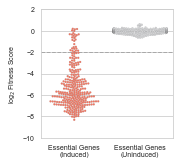

In [29]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (80/25.4, 60/25.4))
fig = plt.figure(figsize = (60/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

df_inducedEss = df_Ess_t0_gpby.copy()
df_uninducedEss = df_drift_leak_gpby_gene_median[(df_drift_leak_gpby_gene_median['gene_name_F2'] != 'b2651') &
                                                (df_drift_leak_gpby_gene_median['Class(1:essential 2:noessential 3:unknown)'] == 1)] #phantom gene

sns.swarmplot(data = [df_inducedEss['LB_ae_avgLR_nmed'].values, df_uninducedEss['drift_avg_d24_LR'].values],
           palette = ['#F37560', '#D1D2D4'], size = 2, edgecolor='gray', linewidth=0.1)

plt.axhline(y=-2, xmin=0, xmax = 1, linewidth=1, color='darkgray', linestyle = '--')
plt.ylim([-10,2])
plt.ylabel(r'log$_2$ Fitness Score', fontsize = 7)
plt.tick_params(axis = 'both', which = 'major', labelsize = 7)
ax111.set_xticklabels(['Essential Genes\n(Induced)', 'Essential Genes\n(Uninduced)'])

plt.savefig('Section 2/Fig_2_b-swarmplot_AltColor_AltDim.pdf', type = 'pdf')

### Stats

In [28]:
x = df_inducedEss['LB_ae_avgLR_nmed'].values
y = df_uninducedEss['drift_avg_d24_LR'].values
statistics, pvalue = mannwhitneyu(x, y, alternative='two-sided')
statistics, pvalue

(1304.0, 2.5285628509732536e-95)

In [29]:
len(x), len(y)

(303, 304)

In [30]:
x = df_inducedEss['LB_ae_avgLR_nmed'].values
y = df_uninducedEss['drift_avg_d24_LR'].values
mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)
cohens_d

3.7339715979830905

In [31]:
df_inducedEss['LB_ae_avgLR_nmed'].describe()

count    303.000000
mean      -5.258101
std        1.978249
min       -8.318961
25%       -6.677639
50%       -5.808374
75%       -4.392410
max        0.186713
Name: LB_ae_avgLR_nmed, dtype: float64

In [32]:
df_uninducedEss['drift_avg_d24_LR'].describe()

count    304.000000
mean      -0.026511
std        0.178858
min       -0.636749
25%       -0.100370
50%       -0.003620
75%        0.079517
max        0.614894
Name: drift_avg_d24_LR, dtype: float64

### Data Export

In [67]:
df_Fig2b = df_inducedEss[['LB_ae_avgLR_nmed', 'ET165_LB_ae_t0', 'Class(1:essential 2:noessential 3:unknown)']].join(df_uninducedEss[['drift_avg_d24_LR']])
df_Fig2b = df_Fig2b[['LB_ae_avgLR_nmed', 'drift_avg_d24_LR', 'ET165_LB_ae_t0', 'Class(1:essential 2:noessential 3:unknown)']].reset_index(drop=False)
df_Fig2b.to_excel('Section 2/Table_Fig-2b.xlsx')
df_Fig2b

,gene_name_F2,LB_ae_avgLR_nmed,drift_avg_d24_LR,ET165_LB_ae_t0,Class(1:essential 2:noessential 3:unknown)
0,accA,-6.603346,-0.051668,107.5,1
1,accB,-7.705001,-0.013092,221.5,1
2,accC,-6.174842,0.041478,101.5,1
3,accD,-7.174079,0.008519,145.5,1
4,acpP,-6.813555,0.095352,205.5,1
...,...,...,...,...,...
298,yihA,-4.923629,0.010765,92.0,1
299,yqgD,-0.013873,-0.082787,50.5,1
300,yqgF,-1.498705,0.032559,73.5,1
301,yrfF,-4.107046,0.091313,91.0,1


## Supplementary Information

### Technical Replicates

#### Visualization

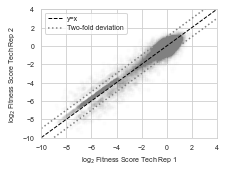

In [33]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

x_col = 'd24_tR2_LR_nmed'
y_col = 'd24_tR3_LR_nmed'

threshold_t0 = 10

df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

plt.scatter(df_iter_filt[x_col], df_iter_filt[y_col], alpha = 0.01, color = 'gray', s = 10)

ax111.set_xlabel('log$_2$ Fitness Score Tech Rep 1', fontsize = 7)
ax111.set_ylabel('log$_2$ Fitness Score Tech Rep 2', fontsize = 7)
ax111.set_xlim(-10,4)
ax111.set_ylim(-10,4)

x = np.arange(-10, 4, 0.1)
y = np.arange(-10, 4, 0.1)
y_plus1 = y + 1
y_minus1 = y - 1
plt.plot(x,y,'k--', linewidth = 1, label = 'y=x')
plt.plot(x, y_plus1, color = 'gray', linestyle = 'dotted', label = 'Two-fold deviation')
plt.plot(x, y_minus1, color = 'gray', linestyle = 'dotted')
plt.tick_params(axis = 'both', which = 'major', labelsize = 7)

plt.legend(loc = 'upper left', fontsize = 7, frameon = True)

plt.savefig('Section 2/SuppFig_Replicates-Tech_tht0=10.pdf', type = 'pdf')

#### Stats

In [34]:
x_col = 'd24_tR2_LR_nmed'
y_col = 'd24_tR3_LR_nmed'
threshold_t0 = 10
df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]
x_data = df_iter_filt[x_col]
y_data = df_iter_filt[y_col]
[pearson_corr_coeff, two_tailed_pval] = pearsonr(x_data, y_data)
[pearson_corr_coeff, two_tailed_pval]

[0.956324967312867, 0.0]

#### Data Export

In [71]:
threshold_t0 = 10
df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

df_SuppFig1a = df_iter_filt[['d24_tR2_LR_nmed', 'd24_tR3_LR_nmed', 'category']].reset_index()
df_SuppFig1a.to_excel('Section 2/Table_SuppFig-1a.xlsx')
df_SuppFig1a

,seq,d24_tR2_LR_nmed,d24_tR3_LR_nmed,category
0,ggtggtgctaatgcgtttca,0.068861,-0.142402,All_Genes
1,cggaatttcaccccgagcgc,0.215013,0.035137,All_Genes
2,atcggcaggcaatgtgtcgc,0.408400,0.170189,All_Genes
3,tcttgactggctaatgcacg,-0.152517,-0.009135,All_Genes
4,ccgaactccctgattccttt,-1.054174,-1.305900,All_Genes
...,...,...,...,...
29948,tgagttgatttaccgccggt,-1.439112,-1.933815,All_Genes
29949,gagttgatttaccgccggtg,-1.482180,-1.907936,All_Genes
29950,cgccccgccctgagaataag,-5.377711,-5.987892,All_Genes
29951,gcgatttgctcaattttttt,-0.562595,-0.682970,All_Genes


### Biological Replicates

#### Visualization

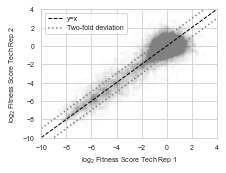

In [35]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

x_col = 'ET165_LB_ae_d24_B5T2_LR_nmed'
y_col = 'ET165_LB_ae_d24_B6T2_LR_nmed'

threshold_t0 = 10

df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

plt.scatter(df_iter_filt[x_col], df_iter_filt[y_col], alpha = 0.01, color = 'gray', s = 10)

ax111.set_xlabel('log$_2$ Fitness Score Tech Rep 1', fontsize = 7)
ax111.set_ylabel('log$_2$ Fitness Score Tech Rep 2', fontsize = 7)
ax111.set_xlim(-10,4)
ax111.set_ylim(-10,4)

x = np.arange(-10, 4, 0.1)
y = np.arange(-10, 4, 0.1)
y_plus1 = y + 1
y_minus1 = y - 1
plt.plot(x,y,'k--', linewidth = 1, label = 'y=x')
plt.plot(x, y_plus1, color = 'gray', linestyle = 'dotted', label = 'Two-fold deviation')
plt.plot(x, y_minus1, color = 'gray', linestyle = 'dotted')
plt.tick_params(axis = 'both', which = 'major', labelsize = 7)

plt.legend(loc = 'upper left', fontsize = 7, frameon = True)

plt.savefig('Section 2/SuppFig_Replicates-Bio_tht0=10.pdf', type = 'pdf')

#### Stats

In [36]:
x_col = 'ET165_LB_ae_d24_B5T2_LR_nmed'
y_col = 'ET165_LB_ae_d24_B6T2_LR_nmed'

threshold_t0 = 10
df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]
x_data = df_iter_filt[x_col]
y_data = df_iter_filt[y_col]
[pearson_corr_coeff, two_tailed_pval] = pearsonr(x_data, y_data)
[pearson_corr_coeff, two_tailed_pval]

[0.8989543280905994, 0.0]

#### Data Export

In [73]:
threshold_t0 = 10
df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

df_SuppFig1b = df_iter_filt[['ET165_LB_ae_d24_B5T2_LR_nmed', 'ET165_LB_ae_d24_B6T2_LR_nmed', 'category']].reset_index()
df_SuppFig1b.to_excel('Section 2/Table_SuppFig-1b.xlsx')
df_SuppFig1b

,seq,ET165_LB_ae_d24_B5T2_LR_nmed,ET165_LB_ae_d24_B6T2_LR_nmed,category
0,ggtggtgctaatgcgtttca,-0.005178,0.171714,All_Genes
1,cggaatttcaccccgagcgc,0.229978,-0.160711,All_Genes
2,atcggcaggcaatgtgtcgc,0.859776,0.753267,All_Genes
3,tcttgactggctaatgcacg,0.058002,0.488431,All_Genes
4,ccgaactccctgattccttt,-0.493732,-0.857396,All_Genes
...,...,...,...,...
29948,tgagttgatttaccgccggt,-0.456864,-0.544928,All_Genes
29949,gagttgatttaccgccggtg,-0.549001,-0.498718,All_Genes
29950,cgccccgccctgagaataag,-6.266928,-5.444932,All_Genes
29951,gcgatttgctcaattttttt,0.372111,0.251539,All_Genes


### Bias

#### Process

In [37]:
threshold_t0 = 10

In [38]:
def calc_GCcontent(seq):
    seq = seq.upper()
    seq_length = len(seq)
    G_count = seq.count('G')
    C_count = seq.count('C')
    GC_content = (G_count + C_count)/seq_length * 100
    return GC_content

In [39]:
df_LRs_GEq_2e6_nmed_bias = df_LRs_GEq_2e6_nmed.copy()
df_LRs_GEq_2e6_nmed_bias['pos'] = df_sgRNA_info_update_3['pos']
df_LRs_GEq_2e6_nmed_bias['GC_content'] = df_LRs_GEq_2e6_nmed_bias['seq'].apply(lambda seq: calc_GCcontent(seq))
df_LRs_GEq_2e6_nmed_bias['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_bias[cols_LB].mean(axis = 1)

In [40]:
df_LRs_GEq_2e6_nmed_bias[['strand', 'pos', 'GC_content', 'LB_ae_avgLR_nmed']].head()

,strand,pos,GC_content,LB_ae_avgLR_nmed
seq,,,,
ggtggtgctaatgcgtttca,-,191,50.0,0.189134
cggaatttcaccccgagcgc,+,837587,65.0,0.462671
atcggcaggcaatgtgtcgc,+,858246,60.0,0.102828
tcttgactggctaatgcacg,+,1089003,50.0,0.245104
ccgaactccctgattccttt,-,3182919,50.0,-0.135161


#### Data Export

In [75]:
df_iter = df_LRs_GEq_2e6_nmed_bias.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

df_SuppFig3abc = df_iter_filt[['strand', 'pos', 'GC_content', 'LB_ae_avgLR_nmed', 'category']].reset_index()
df_SuppFig3abc.to_excel('Section 2/Table_SuppFig-3abc.xlsx')
df_SuppFig3abc

,seq,strand,pos,GC_content,LB_ae_avgLR_nmed,category
0,ggtggtgctaatgcgtttca,-,191,50.0,0.189134,All_Genes
1,cggaatttcaccccgagcgc,+,837587,65.0,0.462671,All_Genes
2,atcggcaggcaatgtgtcgc,+,858246,60.0,0.102828,All_Genes
3,tcttgactggctaatgcacg,+,1089003,50.0,0.245104,All_Genes
4,ccgaactccctgattccttt,-,3182919,50.0,-0.135161,All_Genes
...,...,...,...,...,...,...
29948,tgagttgatttaccgccggt,+,3182691,50.0,-0.481508,All_Genes
29949,gagttgatttaccgccggtg,+,3182692,55.0,-0.456681,All_Genes
29950,cgccccgccctgagaataag,+,3182720,65.0,-4.504771,All_Genes
29951,gcgatttgctcaattttttt,-,3182874,30.0,0.285491,All_Genes


#### Visualize

##### Strand

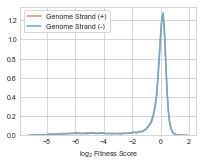

In [41]:
sns.set_style('whitegrid')

fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)


df_iter = df_LRs_GEq_2e6_nmed_bias.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

df_iter_filt_strandplus = df_iter_filt[df_iter_filt['strand'] == '+']
df_iter_filt_strandminus = df_iter_filt[df_iter_filt['strand'] == '-']

sns.distplot(df_iter_filt_strandplus['LB_ae_avgLR_nmed'], hist = False, rug = False, 
             color = sns.color_palette('RdBu',3)[0], label = 'Genome Strand (+)')
sns.distplot(df_iter_filt_strandminus['LB_ae_avgLR_nmed'], hist = False, rug = False, 
             color = sns.color_palette('RdBu',3)[2], label = 'Genome Strand (-)')

plt.legend(fontsize = 7, loc = 'upper left')
plt.xlabel(r'log$_2$ Fitness Score', fontsize = 7)

plt.tick_params(axis = 'both', which = 'major', labelsize = 7)
ax111.get_xaxis().set_tick_params(direction='in', width=0)
ax111.get_yaxis().set_tick_params(direction='in', width=0)

plt.savefig('Section 2/SuppFig_Bias-strand-kdeplot.pdf', type = 'pdf')

In [42]:
df_iter = df_LRs_GEq_2e6_nmed_bias.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]
x = df_iter_filt[df_iter_filt['strand'] == '+']['LB_ae_avgLR_nmed'].values
y = df_iter_filt[df_iter_filt['strand'] == '-']['LB_ae_avgLR_nmed'].values
statistics, pvalue = mannwhitneyu(x, y, alternative='two-sided')
statistics, pvalue #two-tailed

(110520151.5, 0.02991193003439992)

In [43]:
x = df_iter_filt[df_iter_filt['strand'] == '+']['LB_ae_avgLR_nmed'].values
y = df_iter_filt[df_iter_filt['strand'] == '-']['LB_ae_avgLR_nmed'].values
mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)
cohens_d

0.035189437988041763

##### Position

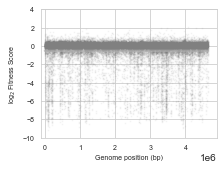

In [46]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

x_col = 'pos'
y_col = 'LB_ae_avgLR_nmed'

threshold_t0 = 0

df_iter = df_LRs_GEq_2e6_nmed_bias.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

#plt.scatter(df_iter_filt[x_col], df_iter_filt[y_col], alpha = 0.01, color = 'gray', s = 10)
sns.regplot(x = x_col, y = y_col, data = df_iter_filt, fit_reg = True, ci = 95,
            scatter_kws = {'alpha':  0.05, 'color' : 'gray', 's':1}, 
            line_kws = {'color' : 'darkgray', 'alpha': 0.6}, ax = ax111)

ax111.set_xlabel('Genome position (bp)', fontsize = 7)
ax111.set_ylabel('log$_2$ Fitness Score', fontsize = 7)
ax111.set_xlim([-100000, 4.9e6])
ax111.set_ylim(-10,4)


plt.tick_params(axis = 'both', which = 'major', labelsize = 7)

plt.savefig('Section 2/SuppFig_Bias-position.pdf', type = 'pdf')

In [47]:
x_col = 'pos'
y_col = 'LB_ae_avgLR_nmed'
threshold_t0 = 0
df_iter = df_LRs_GEq_2e6_nmed_bias.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]
[pearson_corr_coeff, two_tailed_pval] = pearsonr(df_iter_filt[x_col], df_iter_filt[y_col])
[pearson_corr_coeff, two_tailed_pval]

[0.001763404343722514, 0.7487503304545226]

##### GC content

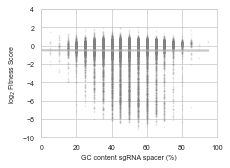

In [48]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

x_col = 'GC_content'
y_col = 'LB_ae_avgLR_nmed'

threshold_t0 = 0

df_iter = df_LRs_GEq_2e6_nmed_bias.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]

#plt.scatter(df_iter_filt[x_col], df_iter_filt[y_col], alpha = 0.01, color = 'gray', s = 10)
sns.regplot(x = x_col, y = y_col, data = df_iter_filt, fit_reg = True, ci = 95,
            scatter_kws = {'alpha':  0.1, 'color' : 'gray', 's':1}, 
            line_kws = {'color' : 'darkgray', 'alpha': 0.6}, ax = ax111)

ax111.set_xlabel('GC content sgRNA spacer (%)', fontsize = 7)
ax111.set_ylabel('log$_2$ Fitness Score', fontsize = 7)
ax111.set_xlim(0,100)
ax111.set_ylim(-10,4)


plt.tick_params(axis = 'both', which = 'major', labelsize = 7)

plt.savefig('Section 2/SuppFig_Bias-GCcontent.pdf', type = 'pdf')

In [49]:
x_col = 'GC_content'
y_col = 'LB_ae_avgLR_nmed'
threshold_t0 = 0
df_iter = df_LRs_GEq_2e6_nmed_bias.copy()
df_iter_filt = df_iter[df_iter['ET165_LB_ae_t0'] >= threshold_t0]
[pearson_corr_coeff, two_tailed_pval] = pearsonr(df_iter_filt[x_col], df_iter_filt[y_col])
[pearson_corr_coeff, two_tailed_pval]

[-0.002870703868697104, 0.6020830264599796]